In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
%load_ext autoreload
%autoreload 2

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 22.179666826381407


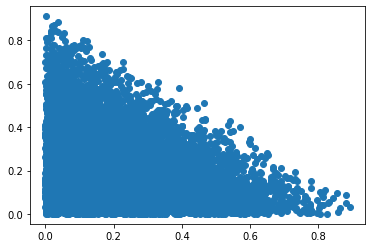

In [3]:
N = 10000
NumberofSources = 5
NumberofMixtures = 10

S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
# S = L @ S
S = S / np.sum(S, axis = 0)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))
plt.scatter(S[0,:], S[1,:])

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 200
model = LDMIBSS(s_dim = s_dim, x_dim = x_dim,
                set_ground_truth = True, S = S, A = A)

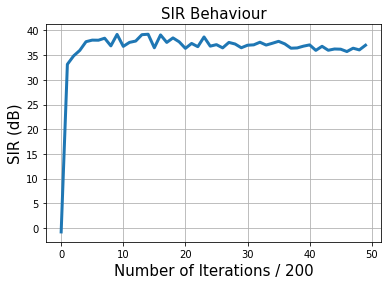

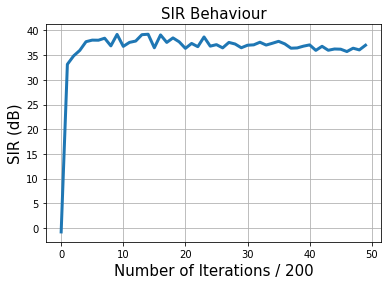

In [5]:
model.fit_batch_simplex(X, epsilon = 1e-5, mu_start = 100, n_iterations = 10000, 
                           method = "correlation", debug_iteration_point = debug_iteration_point,
                           plot_in_jupyter = True)

In [6]:
W = model.W
Y = W @ X
10 * np.log10(CalculateSINR(Y, S)[0])

23.129851447802572

In [7]:
CalculateSIR(A,W)

(36.68202924125306, 5)

In [8]:
Y = W @ X
Y.shape, X.shape, S.shape
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
snr(S.T, Y_.T)

array([26.1930204 , 24.86275949, 22.9762804 , 20.73368325, 21.82554604])

In [9]:
def projection_simplex(V, z=1, axis=None):
    """
    Projection of x onto the simplex, scaled by z:
        P(x; z) = argmin_{y >= 0, sum(y) = z} ||y - x||^2
    z: float or array
        If array, len(z) must be compatible with V
    axis: None or int
        axis=None: project V by P(V.ravel(); z)
        axis=1: project each V[i] by P(V[i]; z[i])
        axis=0: project each V[:, j] by P(V[:, j]; z[j])
    """
    if axis == 1:
        n_features = V.shape[1]
        U = np.sort(V, axis=1)[:, ::-1]
        z = np.ones(len(V)) * z
        cssv = np.cumsum(U, axis=1) - z[:, np.newaxis]
        ind = np.arange(n_features) + 1
        cond = U - cssv / ind > 0
        rho = np.count_nonzero(cond, axis=1)
        theta = cssv[np.arange(len(V)), rho - 1] / rho
        return np.maximum(V - theta[:, np.newaxis], 0)

    elif axis == 0:
        return projection_simplex(V.T, z, axis=1).T

    else:
        V = V.ravel().reshape(1, -1)
        return projection_simplex(V, z, axis=1).ravel()

In [10]:
%timeit ProjectColstoSimplex(S)

851 µs ± 7.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
np.linalg.norm(projection_simplex(S, 1, 0) - ProjectColstoSimplex(S))

0.0

In [12]:
%timeit projection_simplex(S, 1, 0)

843 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit ProjectRowstoL1NormBall(S.T).T

1.68 ms ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
